# Greenhouse Model

## Import dependencies and data

In [1]:
# import dependencies
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

In [4]:
def data_reduce(data, m):
    idxObj = zip(
        data.index.get_level_values(0),
        data.index.get_level_values(1),
        data.index.get_level_values(2),
        data.index.get_level_values(3) // m
    )

    index = pd.MultiIndex.from_tuples(
        tuples=idxObj,
        names=['month', 'day', 'hour', 'minute']
    )

    data.index = index
    dates = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()[('time', 'date')]
    data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
    return data, dates

In [5]:
data, _ = data_reduce(data, 5)

## Model

In [49]:
A = 300 # floor area
V = 3 * A # volume
gamma = 30 # roof angle
Ar = A / np.cos(gamma*np.pi/180) # roof area
Aw = np.sqrt(A) * 3 * 3 # wall area

eta = 0.7 # transmissivity of roof
U = 2.9 # heat transfer coefficient
Er = 0.95 # roof emission coefficient
sigma=5.67051e-8 # stefan-boltzmann constant
rho = 1.1769 # density of air
Cp = 1006.3 # heat capacity of air
L = 2.260 * 10**3 # latent heat vaporization of water

solar_gain = 0.81
solar_transm = 0.79

In [100]:
temp_df = data[[
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('humidity', 'TA01_GT10X_GM10X_abs'),
    ('humidity', 'outdoor_abs'),
    ('humidity', 'TA01_GT401_GM401_abs'),
    ('humidity', 'TA02_GT401_GM401_abs'),
    ('sun', 'gsi'),
    ('flow', 'TA01_GP101'),
    ('flow', 'TA02_GP101')
]].iloc[:-25000].values

In [101]:
temp = temp_df[0, 0]

flux_list = []
latent_list = []
thermal_list = []
pred_temp = []
temp_diff = []

In [102]:
prev_temp = temp

In [103]:
for step in temp_df:
    temp, temp_out, temp_vent1, temp_vent2, humid, humid_out, humid_vent1, humid_vent2, gsi, flow_vent1, flow_vent2 = step
    
#     irradiance_gh = temp ** 4 * sigma * (Ar + Aw) / A
#     irradiance_net = eta * gsi - irradiance_gh
#     thermal_loss = (Ar + Aw) / A * U * (temp_out - temp)
#     sensible_flux_1 = (flow_vent1 / 1000) / A * Cp * rho * (temp_vent1 - temp)
#     sensible_flux_2 = (flow_vent2 / 1000) / A * Cp * rho * (temp_out - temp)
#     latent_flux_1 = (flow_vent1 / 1000) / A * L * (humid_vent1 - humid)
#     latent_flux_2 = (flow_vent2 / 1000) / A * L * (humid_out - humid)
    
    sensible_flux = (Cp * rho) / (A * 1000) * (flow_vent1 * (temp_vent1 - prev_temp) + flow_vent2 * (temp_out - prev_temp)) * 300
    latent_flux = (rho * L) / (A * 1000) * (flow_vent1 * (humid_vent1 - humid) + flow_vent2 * (humid_out - humid)) * 300
    infiltration = rho * eta * V / A * Cp * (temp_out - prev_temp) * 300
    thermal_loss = (Ar + Aw) / A * U * (temp_out - prev_temp) * 300
    #irradiance = solar_gain * solar_transm * gsi * 0.3
    
#     temp_diff = (irradiance_net + thermal_loss + sensible_flux_1 + sensible_flux_2) / Cp# + latent_flux_1 + latent_flux_2) / Cp
#     temp_diff = sensible_flux / Cp

    #temp += temp_diff
    # change
    temp_ch = temp - prev_temp
    prev_temp = temp
    
    pred_temp.append((thermal_loss) * A / (Cp * rho) / V)
    flux_list.append(sensible_flux)
    latent_list.append(latent_flux)
    thermal_list.append(thermal_loss)
    temp_diff.append(temp_ch)

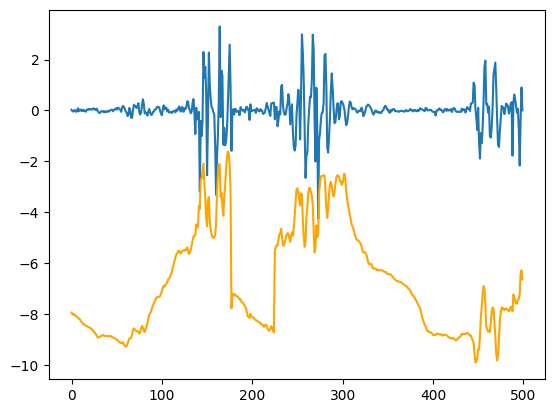

In [104]:
fig, ax = plt.subplots()

ax.plot(temp_diff[-500:])
#ax_twin = ax.twinx()
ax.plot(pred_temp[-500:], 'orange')